In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Data Prepration for India
Data is imported from John Hopkins GitHub Repo and can be used for more analysis

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})
# Check null values
full_df.isnull().sum()

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

df_india=add_rates(df_india)
df=pd.DataFrame(df_india['Confirmed'])
df = df.replace(0, np.nan)
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True)
#df.drop('index',axis=1,inplace=True)

df['index']=pd.Series(range(1,len(df)+1))
print(df)

Country               0
Province/State    22400
Lat                   0
Long                  0
Date                  0
Confirmed             0
Recoveries            0
Deaths                0
dtype: int64

     index  Confirmed
0        1        1.0
1        2        1.0
2        3        1.0
3        4        2.0
4        5        3.0
..     ...        ...
115    116   138536.0
116    117   144950.0
117    118   150793.0
118    119   158086.0
119    120   165386.0

[120 rows x 2 columns]


In [3]:
df_india=add_rates(df_india)

In [4]:
df=pd.DataFrame(df_india['Confirmed'])

In [5]:
df = df.replace(0, np.nan)
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)

In [6]:
df['New Cases']=df['Confirmed']-df['Confirmed'].shift(1)

In [7]:
#df['index']=pd.Series(range(1,len(df)+1))

## Data Prepration to feed LSTM Model

In [35]:
data=df.values

In [36]:
np.set_printoptions(suppress=True)

In [37]:
train=data[0:100]
test=data[100:]

In [38]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(train)

Here for ever 5 data point model will learn to predict next value and in this way data is prepared here

In [39]:
X_Train = []
Y_Train = []

for i in range(5, Train.shape[0]):
    
    X_Train.append(Train[i-5:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(95, 5)
(95,)


In [40]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

## Stacked LSTM Model

In [20]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [22]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 16)

Epoch 1/30
95/95 [==============================] - 3s 27ms/step - loss: 0.0761
Epoch 2/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0604
Epoch 3/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 4/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 5/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 6/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 7/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 8/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 9/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 10/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 11/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 12/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 13/30
95/95 [=============================

In [23]:
hist=regressor.history

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

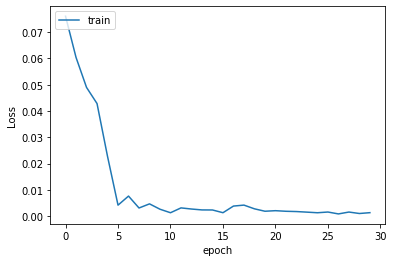

In [24]:
plt.plot(hist.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# We need to Reshape
test= test.reshape(-1,1)

# Normalize the Dataset
test = sc.transform(test)

X_test = []
for i in range(5,len(test)):
    X_test.append(test[i-5:i, 0])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_cases = regressor.predict(X_test)

In [27]:
predicted_cases.shape

(15, 1)

In [ ]:
def create_batch(data,step):
    data_list = []
    for i in range(step,len(data)):
        data_list.append(data[i-step:i, 0])
    data_batch = np.array(data_list)
    return data_batch

Text(0, 0.5, 'No of Cases')

Text(0.5, 0, 'No. of days after 9 May')

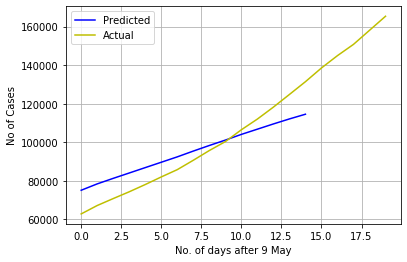

In [29]:
plt.plot(sc.inverse_transform(predicted_cases),c='b')
plt.plot(sc.inverse_transform(test),c='y')
plt.ylabel('No of Cases')
plt.xlabel('No. of days after 9 May')
plt.legend(['Predicted', 'Actual'], loc='upper left')
plt.grid()
plt.show()

## Training the model on whole data

In [7]:
data=df.values

In [37]:
len(data)

120

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data)

In [11]:
X_Train = []
Y_Train = []

for i in range(5, Train.shape[0]):
    
    X_Train.append(Train[i-5:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(115, 5)
(115,)


In [12]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [13]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 16)

Epoch 1/30
115/115 [==============================] - 2s 15ms/step - loss: 0.0811
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0510
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0303
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 6/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 8/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 9/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 10/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 11/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 12/30
115/115 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 13/30
115/115 [===

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

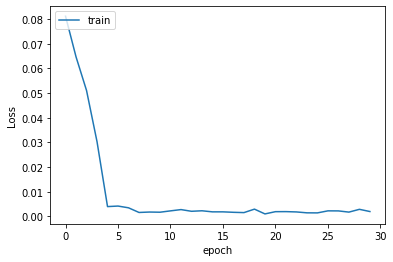

In [18]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
regressor.predict(X_Train[-1].reshape(1,5,1))

array([[1.0190598]], dtype=float32)

In [31]:
sc.inverse_transform([[1.0190598]])

array([[168538.205023]])

### Prediction for new cases

In [8]:
df

,Confirmed,New Cases
0,1.0,NaN
1,1.0,0.0
2,1.0,0.0
3,2.0,1.0
4,3.0,1.0
...,...,...
115,138536.0,7113.0
116,144950.0,6414.0
117,150793.0,5843.0
118,158086.0,7293.0


In [9]:
df=df.iloc[2:]

In [10]:
df.reset_index(drop=True)

,Confirmed,New Cases
0,1.0,0.0
1,2.0,1.0
2,3.0,1.0
3,3.0,0.0
4,3.0,0.0
...,...,...
113,138536.0,7113.0
114,144950.0,6414.0
115,150793.0,5843.0
116,158086.0,7293.0


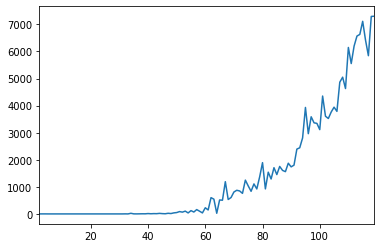

In [11]:
df['New Cases'].plot()

In [12]:
data=df['New Cases'].values

In [13]:
np.set_printoptions(suppress=True)

In [14]:
data=data.reshape(-1,1)

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Train = sc.fit_transform(data)

In [16]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(98, 20)
(98,)


In [17]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [18]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [20]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 16)

Epoch 1/30
98/98 [==============================] - 2s 21ms/step - loss: 0.8702
Epoch 2/30
98/98 [==============================] - 0s 3ms/step - loss: 0.1634
Epoch 3/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 4/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0971
Epoch 5/30
98/98 [==============================] - 0s 4ms/step - loss: 0.0918
Epoch 6/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0731
Epoch 7/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0522
Epoch 8/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 9/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 10/30
98/98 [==============================] - 0s 3ms/step - loss: 0.0464
Epoch 11/30
98/98 [==============================] - 0s 4ms/step - loss: 0.0548
Epoch 12/30
98/98 [==============================] - 0s 4ms/step - loss: 0.0487
Epoch 13/30
98/98 [=============================

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

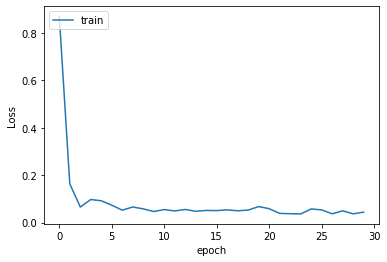

In [21]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
pred=[]
for i in X_Train[-1]:
    pred.append(i)

In [25]:
pred.append(regressor.predict(X_Train[-1].reshape(1,20,1)))

In [26]:
for i in range(20):
    pred.reverse()
    pred.pop()
    pred.reverse()
    pred.append(regressor.predict(np.array(pred).reshape(1,20,1)))
    print(len(pred))

array([0.95583231])

21


array([0.8421618])

21


array([1.45234117])

21


array([1.08524939])

21


array([1.04440673])

21


array([1.16201389])

21


array([1.25009623])

21


array([1.17382381])

21


array([1.70379412])

21


array([1.79532103])

21


array([1.58864737])

21


array([2.33513294])

21


array([2.04283734])

21


array([2.36022903])

21


array([2.54229868])

21


array([2.57231557])

21


array([2.81048236])

21


array([2.46651834])

21


array([2.18554058])

21


array([2.89905678])

21


In [29]:
prediction=sc.inverse_transform(pred)

In [42]:
forcast=[]
a=0
for i in prediction:
    for j in i:
        a=a+j
        print(a)
        #forcast.append(j)

[6769.5786]
[13669.094]
[20705.838]
[27822.387]
[35049.54]
[42385.734]
[49817.105]
[57333.438]
[64935.387]
[72588.766]
[80288.35]
[88044.3]
[95819.69]
[103629.29]
[111459.21]
[119302.37]
[127158.32]
[135018.]
[142896.78]
[150806.8]
[158720.44]


In [38]:
forcast.s

AttributeError: 'list' object has no attribute 'sum'

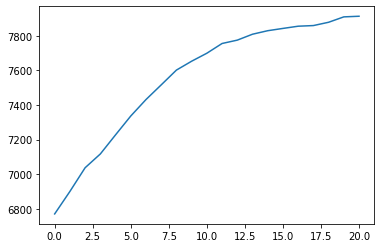

In [37]:
plt.plot(forcast)

In [21]:
test_p=create_batch(predicted_cases,5)

In [ ]:
# We need to Reshape
test= test.reshape(-1,1)

# Normalize the Dataset
test = sc.transform(test)

X_test = []
for i in range(5,len(test)):
    X_test.append(test[i-5:i, 0])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_cases = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_cases = sc.inverse_transform(predicted_cases)

In [28]:
predicted_data=[]
for i in range(10):
    test_p=create_batch(predicted_cases,5)
    test_p = np.reshape(test_p, (test_p.shape[0], test_p.shape[1], 1))
    
    predicted_cases = regressor.predict(test_p)
    predicted_data.append(predicted_cases)
    print(i)

0
1


IndexError: tuple index out of range

In [18]:
# We need to Reshape
test= test.reshape(-1,1)

# Normalize the Dataset
test = sc.transform(test)

X_test = []
for i in range(5,len(test)):
    X_test.append(test[i-5:i, 0])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_cases = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_cases = sc.inverse_transform(predicted_cases)

In [32]:
def create_batch(data,step):
    data_list = []
    for i in range(step,len(data)):
        data_list.append(data[i-step:i, 0])
    data_batch = np.array(data_list)
    return data_batch

In [35]:
    test_p=create_batch(predicted_cases,5)

In [37]:
test_p.shape

(8, 5)

In [ ]:
predicted_data=[]
for i in range(10):
    test_p=create_batch(predicted_cases,5)
    
    
    test= test.reshape(-1,1)
    test = sc.transform(test)
    
    test_p=create_batch(predicted_cases,5)
    test_p = np.reshape(test_p, (test_p.shape[0], test_p.shape[1], 1))

In [34]:
create_batch(predicted_cases,5)

(8, 5)

In [20]:
test=sc.inverse_transform(test)

Text(0, 0.5, 'No of Cases')

Text(0.5, 0, 'No. of days after 9 May')

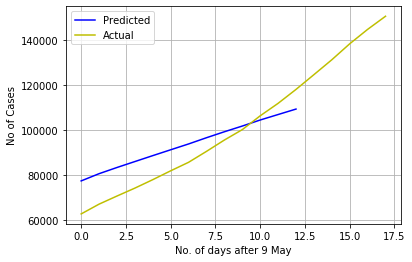

In [26]:
plt.plot(predicted_cases,c='b')
plt.plot(test,c='y')
plt.ylabel('No of Cases')
plt.xlabel('No. of days after 9 May')
plt.legend(['Predicted', 'Actual'], loc='upper left')
plt.grid()
plt.show()